<a href="https://colab.research.google.com/github/Haffizuddin7899/Expression-Classification-from-Facial-Images/blob/main/Project_Title_Expression_Classification_from_Facial_Images_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
!ls /content/drive/MyDrive/Fiver/p2/Project


'General Data.zip'  'New_Notebook_00 (4).ipynb'


In [ ]:
!7z x "/content/drive/MyDrive/Fiver/p2/Project/General Data.zip" #replace with originel ziped dataset



7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/Fiver/p2/Project/                                                  1 file, 371038120 bytes (354 MiB)

Extracting archive: /content/drive/MyDrive/Fiver/p2/Project/General Data.zip
  2% 4096 Open               21% 36864 Open                28% 49152 Open                45% 77824 Open                77% 131072 Open                 86% 147456 Open                --
Path = /content/drive/MyDrive/Fiver/p2/Project/General Data.zip
Type = zip
Physical Size =

In [ ]:
!cp -r /content/origin /content/drive/MyDrive/Fiver/p2/DATA

In [ ]:
# Define file paths for label information and image data
label_file_path = "/content/drive/MyDrive/project/data/label/label.lst"
images_folder_path = "/content/drive/MyDrive/project/origin"

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Read the label information into a pandas DataFrame
df_info = pd.read_csv(label_file_path, sep=" ", header=None)
col_names = "image_name face_id_in_image face_box_top face_box_left face_box_right face_box_bottom face_box_cofidence expression_label".split()
df_info.columns = col_names

In [ ]:
# Filter the DataFrame to keep only the confident face detections
df_sel = df_info[df_info.face_box_cofidence > 30]


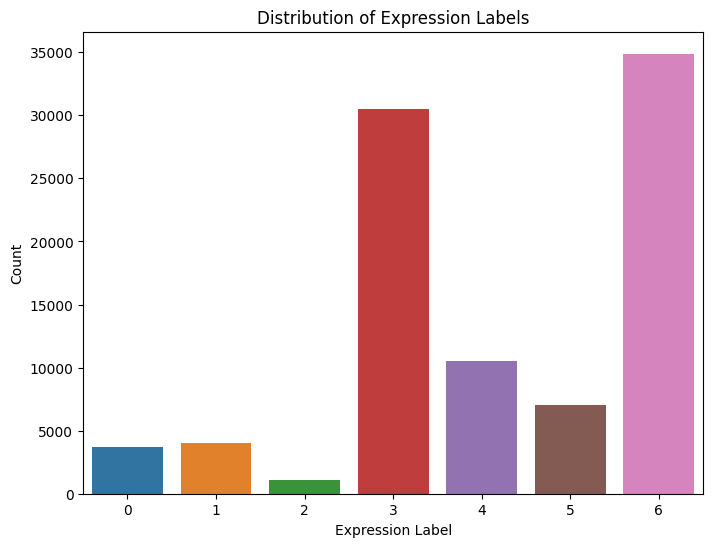

In [ ]:
# Plot a bar chart for expression labels to understand the label distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='expression_label', data=df_info)
plt.xlabel('Expression Label')
plt.ylabel('Count')
plt.title('Distribution of Expression Labels')
plt.show()

In [ ]:
# Prepare the data for model training by cropping and resizing the images
x = []
y = []
for i, row in df_sel.sample(5000).iterrows():
    img_name = row["image_name"]
    x1 = row["face_box_left"]
    x2 = row["face_box_right"]
    y1 = row["face_box_top"]
    y2 = row["face_box_bottom"]
    label = row["expression_label"]
    img_path = os.path.join(images_folder_path, img_name)
    img = cv2.imread(img_path)
    # Check if img is not None
    if img is not None:
        # Crop the image using the provided coordinates
        cropped_img = img[y1:y2, x1:x2]
    else:
        continue

    if cropped_img is not None:
        # Resize the cropped image to a fixed size (e.g., 64x64)
        resized_face = cv2.resize(cropped_img, (64, 64))
    else:
        continue

    # Normalize the image data (scaling pixel values to the range [0, 1])
    normalized_face = resized_face / 255.0
    x.append(normalized_face)
    y.append(label)

In [ ]:
# Convert the lists to numpy arrays
X = np.array(x)
Y = np.array(y)

In [ ]:
# Split the data into training (70%), validation (15%), and testing (15%) sets
from sklearn.model_selection import train_test_split

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Testing set size:", len(X_test))

Training set size: 2153
Validation set size: 462
Testing set size: 462


In [ ]:
# One-hot encode the target labels for training and validation sets
from keras.utils import to_categorical

Y_train_one_hot = to_categorical(Y_train, num_classes=7)
Y_val_one_hot = to_categorical(Y_val, num_classes=7)
Y_test_one_hot = to_categorical(Y_test, num_classes=7)

In [ ]:
# Import necessary libraries for building the model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [ ]:
# Create the model architecture
emotion_model = Sequential()

emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7, activation='softmax'))

In [ ]:
# Compile the model
emotion_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Print model summary for debugging
emotion_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 30, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 128)       0         
 g2D)                                                   

In [ ]:
# Data augmentation using ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

datagen.fit(X_train)


In [ ]:
# Create a TensorBoard callback to visualize training progress
from keras.callbacks import TensorBoard

log_dir = "/content/drive/MyDrive/project/logs"
tensorboard_callback = TensorBoard(log_dir=log_dir)

# Train the model using the augmented data and TensorBoard callback
history = emotion_model.fit(datagen.flow(X_train, Y_train_one_hot, batch_size=32),
                            epochs=100,
                            validation_data=(X_val, Y_val_one_hot),
                            callbacks=[tensorboard_callback])


Epoch 1/100
68/68 [==============================] - 16s 63ms/step - loss: 1.4166 - accuracy: 0.4366 - val_loss: 1.4187 - val_accuracy: 0.4437
Epoch 2/100
68/68 [==============================] - 7s 99ms/step - loss: 1.3685 - accuracy: 0.4547 - val_loss: 1.4053 - val_accuracy: 0.4437
Epoch 3/100
68/68 [==============================] - 4s 61ms/step - loss: 1.3491 - accuracy: 0.4640 - val_loss: 1.4020 - val_accuracy: 0.4437
Epoch 4/100
68/68 [==============================] - 3s 43ms/step - loss: 1.3477 - accuracy: 0.4645 - val_loss: 1.4032 - val_accuracy: 0.4502
Epoch 5/100
68/68 [==============================] - 3s 44ms/step - loss: 1.3385 - accuracy: 0.4654 - val_loss: 1.3891 - val_accuracy: 0.4524
Epoch 6/100
68/68 [==============================] - 3s 49ms/step - loss: 1.3357 - accuracy: 0.4561 - val_loss: 1.4209 - val_accuracy: 0.4459
Epoch 7/100
68/68 [==============================] - 3s 43ms/step - loss: 1.3235 - accuracy: 0.4710 - val_loss: 1.3768 - val_accuracy: 0.4459
Epoch

In [ ]:
# Import confusion matrix functionality
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [ ]:
# Make predictions on the test set
Y_pred_one_hot = emotion_model.predict(X_test)
Y_pred = np.argmax(Y_pred_one_hot, axis=1)

15/15 [==============================] - 0s 5ms/step


In [ ]:
# Get the true labels for the test set
Y_test_true = np.argmax(Y_test_one_hot, axis=1)

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(Y_test_true, Y_pred)



In [ ]:
# Save the trained model to an HDF5 file
model_save_path = "/content/drive/MyDrive/project/emotion_model.h5"
emotion_model.save(model_save_path)

print(f"Model saved to {model_save_path}")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /content/drive/MyDrive/project/emotion_model.h5


In [ ]:
# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

NameError: ignored

<Figure size 800x600 with 0 Axes>